In [1]:
!ls

bengin_traffic.csv  sample_data


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

In [0]:
df_bening = pd.read_csv('bengin_traffic.csv')

In [4]:
df_bening.shape

(40395, 115)

There should have been 49,548 instances

In [0]:
#df_bening = (df_bening - df_bening.mean()) / df_bening.std()
#df_bening = scale(df_bening)

In [0]:
scaler = MinMaxScaler()
df_bening = scaler.fit_transform(df_bening)

In [0]:
x_train, x_opt, x_test = np.split(df_bening, [int((1/3)*len(df_bening)), int((2/3)*len(df_bening))])

In [87]:
print(x_train.shape)
print(x_opt.shape)
print(x_test.shape)

(40395, 115)
(13465, 115)
(13465, 115)
(13465, 115)


In [0]:
nb_epoch = 800
input_dim = x_train.shape[1]
learning_rate = 0.012

autoencoder = Sequential()
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh", input_dim=input_dim))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.25 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh"))
autoencoder.add(Dense(input_dim))

In [68]:
autoencoder.compile(loss='mean_squared_error',
                    optimizer='sgd')

cp = ModelCheckpoint(filepath="autoencoder_traffic_minmax.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    validation_data=(x_opt, x_opt),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 13465 samples, validate on 13465 samples
Epoch 1/800
13465/13465 [==============================] - 2s 113us/step - loss: 0.0344 - val_loss: 0.0252
Epoch 2/800
13465/13465 [==============================] - 1s 89us/step - loss: 0.0203 - val_loss: 0.0153
Epoch 3/800
13465/13465 [==============================] - 1s 89us/step - loss: 0.0124 - val_loss: 0.0094
Epoch 4/800
13465/13465 [==============================] - 1s 89us/step - loss: 0.0081 - val_loss: 0.0064
Epoch 5/800
13465/13465 [==============================] - 1s 90us/step - loss: 0.0059 - val_loss: 0.0050
Epoch 6/800
13465/13465 [==============================] - 1s 94us/step - loss: 0.0050 - val_loss: 0.0044
Epoch 7/800
13465/13465 [==============================] - 1s 91us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 8/800
13465/13465 [==============================] - 1s 89us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 9/800
13465/13465 [==============================] - 1s 92us/step - loss: 0.0042 - val_loss: 0.

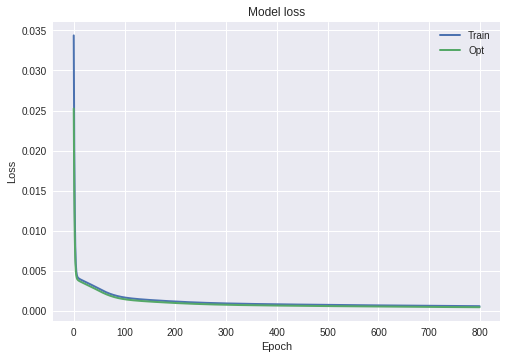

In [69]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Opt')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [0]:
x_opt_predictions = autoencoder.predict(x_opt)

In [0]:
mse = np.mean(np.power(x_opt - x_opt_predictions, 2), axis=1)

In [59]:
mse.shape

(13465,)

In [72]:
mse

array([5.67163702e-04, 9.09609758e-05, 7.24533507e-05, ...,
       2.23024920e-04, 8.57839622e-04, 4.44349298e-04])

In [74]:
print(mse.mean())
print(mse.min())
print(mse.max())
print(mse.std())

0.00046100249961346953
5.424287459070545e-06
0.1799505412418943
0.003796464687653877


In [75]:
tr = mse.mean() + mse.std()
tr

0.004257467187267347

Claimed tr for this dataset is 0.042

In [0]:
x_test_predictions = autoencoder.predict(x_test)

In [84]:
mse_test = np.mean(np.power(x_test - x_test_predictions, 2), axis=1)
mse_test.shape

(13465,)

In [89]:
over_tr = mse_test > tr
false_positives = sum(over_tr)
print(false_positives)
fpr = false_positives / mse_test.shape[0]
print(fpr)

187
0.013887857408095061


Claimed window size is 82

In [93]:
false_alarms = 0
w = 82
for i in range(0, len(over_tr) - w):
  fp = sum(over_tr[i:i+w])
  if fp/2 > w:
    false_alarms = false_alarms + 1
    
print('False alarms %d' % false_alarms)
    

False alarms 0
